In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Download historical data for XOP
data = yf.download("XOP", start="2021-01-01", end="2024-12-10", interval='1d')

#data = data[['Close','High', 'Low', 'Open', 'Volume']]

# Target = Return over next day
data['Return'] = data['Close'] - data['Open']

# Extra feature engineering
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['MA_30'] = data['Close'].rolling(window=30).mean()
data['Daily_Range'] = data['High'] - data['Low']
data = data.dropna()

# We will use past window_size days of close prices to predict the next day direction
window_size = 70
feature_cols = ['Close', 'Open', 'MA_10', 'MA_30', 'Daily_Range']
X = []
y = []

# Extract sequences of length window_size and the corresponding target
for i in range(len(data) - window_size):
    sequence = data.iloc[i:i+window_size][feature_cols].values
    X.append(sequence)
    y.append(data.iloc[i+window_size]['Return'])

X = np.array(X)
y = np.array(y).reshape(-1, 1)

#device = torch.device('cuda')

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

last_train_date = data.index[len(X_train)].date()
print("Last train date: ",last_train_date)

X_train_distinct = [seq[0] for seq in X_train[:-1]] + [seq[-1] for seq in X_train[1:]]
scalar_x = StandardScaler()
scalar_x.fit(X_train_distinct)

X_train_shape = X_train.shape
X_test_shape = X_test.shape

X_train = scalar_x.transform(X_train.reshape(-1, len(feature_cols))).reshape(X_train_shape)
X_test = scalar_x.transform(X_test.reshape(-1, len(feature_cols))).reshape(X_test_shape)

scalar_y = StandardScaler()
y_train = scalar_y.fit_transform(y_train)
y_test = scalar_y.transform(y_test)

# Convert data to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)


Last train date:  2024-02-20


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.h0 = nn.Parameter(torch.randn(self.num_layers, 1, self.hidden_size))
        self.c0 = nn.Parameter(torch.randn(self.num_layers, 1, self.hidden_size))

        self.fc1 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)

        h0 = self.h0.repeat(1, batch_size, 1) # Repeat for batch size
        c0 = self.c0.repeat(1, batch_size, 1)

        # Pass through LSTM
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # Take the output of the last time step

        # Pass through linear layer
        out = self.fc1(out)  # Regression output
        return out


In [ ]:
# Hyperparameters
input_size = len(feature_cols)
hidden_size = 32
num_layers = 1

batch_size = 16
learning_rate = 0.00005

model = LSTMModel(input_size, hidden_size, num_layers, dropout=0.3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

dataset = TensorDataset(X_train_t, y_train_t)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda')
print(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


cuda


In [ ]:
# Move validation data to the same device
model.to(device)
criterion.to(device)
X_test_t = X_test_t.to(device)
y_test_t = y_test_t.to(device)

# Training loop
model.train()

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0

    # Training step
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * len(X_batch)

    # Average training loss for the epoch
    epoch_train_loss /= len(X_train_t)

    # Validation step (no gradient computation)
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_t)
        val_loss = criterion(outputs, y_test_t).item()

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {epoch_train_loss:.4f}, "
          f"Validation Loss: {val_loss:.4f}")


Epoch [1/100], Training Loss: 0.9973, Validation Loss: 0.5171
Epoch [2/100], Training Loss: 0.9967, Validation Loss: 0.5168
Epoch [3/100], Training Loss: 0.9963, Validation Loss: 0.5166
Epoch [4/100], Training Loss: 0.9959, Validation Loss: 0.5164
Epoch [5/100], Training Loss: 0.9955, Validation Loss: 0.5162
Epoch [6/100], Training Loss: 0.9952, Validation Loss: 0.5160
Epoch [7/100], Training Loss: 0.9948, Validation Loss: 0.5158
Epoch [8/100], Training Loss: 0.9945, Validation Loss: 0.5157
Epoch [9/100], Training Loss: 0.9941, Validation Loss: 0.5155
Epoch [10/100], Training Loss: 0.9938, Validation Loss: 0.5154
Epoch [11/100], Training Loss: 0.9935, Validation Loss: 0.5152
Epoch [12/100], Training Loss: 0.9932, Validation Loss: 0.5151
Epoch [13/100], Training Loss: 0.9929, Validation Loss: 0.5149
Epoch [14/100], Training Loss: 0.9926, Validation Loss: 0.5148
Epoch [15/100], Training Loss: 0.9923, Validation Loss: 0.5147
Epoch [16/100], Training Loss: 0.9920, Validation Loss: 0.5145
E

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Test the model
X_test_t = X_test_t.to(device)
y_test_t = y_test_t.to(device)
X_train_t = X_train_t.to(device)
y_train_t = y_train_t.to(device)

model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_t).cpu().numpy()
    y_true_test = y_test_t.cpu().numpy()
    y_pred_train = model(X_train_t).cpu().numpy()
    y_true_train = y_train_t.cpu().numpy()

# Denormalize predictions and true values
y_pred_test_denorm = scalar_y.inverse_transform(y_pred_test)
y_true_test_denorm = scalar_y.inverse_transform(y_true_test)
y_pred_train_denorm = scalar_y.inverse_transform(y_pred_train)
y_true_train_denorm = scalar_y.inverse_transform(y_true_train)

# Calculate evaluation metrics on denormalized values
mse_test = mean_squared_error(y_true_test_denorm, y_pred_test_denorm)
mae_test = mean_absolute_error(y_true_test_denorm, y_pred_test_denorm)
r2_test = r2_score(y_true_test_denorm, y_pred_test_denorm)

mse_train = mean_squared_error(y_true_train_denorm, y_pred_train_denorm)
mae_train = mean_absolute_error(y_true_train_denorm, y_pred_train_denorm)
r2_train = r2_score(y_true_train_denorm, y_pred_train_denorm)

print("In sample (train data)")
print("---------------------")
print(f"Mean Squared Error (MSE): {mse_train:.4f}")
print(f"Mean Absolute Error (MAE): {mae_train:.4f}")
print(f"R² Score: {r2_train:.4f}")
print("\n")
print("Out of sample (validation/test data)")
print("---------------------")
print(f"Mean Squared Error (MSE): {mse_test:.4f}")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
print(f"R² Score: {r2_test:.4f}")



In sample (train data)
---------------------
Mean Squared Error (MSE): 5.4560
Mean Absolute Error (MAE): 1.7810
R² Score: 0.0350


Out of sample (validation/test data)
---------------------
Mean Squared Error (MSE): 2.8996
Mean Absolute Error (MAE): 1.3573
R² Score: 0.0119


In [ ]:
# Parameters
small_margin = 0.005  # 0.5% predicted return threshold
large_margin = 0.01   # 1% predicted return threshold
stop_loss = -0.005     # -1% stop loss
take_profit = 0.02    # 2% take profit
initial_balance = 2000  # Starting capital

# Load hourly data
ticker = "XOP"
data_hourly = yf.download(ticker, interval="1h", start=last_train_date, end="2024-12-12")
data_hourly = data_hourly.sort_index()

# Prepare daily data for predictions
data_daily = yf.download(ticker, interval="1d", start=last_train_date, end="2024-12-12")
data_daily = data_daily[['Open', 'High', 'Low', 'Close', 'Volume']]

# Feature engineering (e.g., moving averages, volatility)
data_daily['MA_10'] = data_daily['Close'].rolling(window=10).mean()
data_daily['MA_30'] = data_daily['Close'].rolling(window=30).mean()
data_daily['Daily_Range'] = data_daily['High'] - data_daily['Low']

# Prepare sequences for LSTM input
X = []
dates = []

for i in range(len(data_daily) - window_size):
    sequence = data_daily.iloc[i:i+window_size][feature_cols].values
    X.append(sequence)
    dates.append(data_daily.index[i + window_size].date())  # day right after rolling window = day we use this data to predict

X = np.array(X)

# Rolling standardization
X_scaled = []

# Use only data in current window to standardize (no future data)
for i in range(len(X)):
    scaler = StandardScaler()
    X_scaled.append(scaler.fit_transform(X[i]))

X_scaled = np.array(X_scaled)
X_t = torch.tensor(X_scaled, dtype=torch.float32).to(device)

# Generate predictions using the pre-trained LSTM model
model.eval()
with torch.no_grad():
    y_pred = model(X_t).cpu().numpy()

# Create a DataFrame for predictions (daily predictions)
predictions_df = pd.DataFrame({
    'Date': dates,
    'Predicted_Return': scalar_y.inverse_transform(y_pred).flatten() # use training scalar to get return in original units
})
predictions_df.set_index('Date', inplace=True)

data_hourly['Date'] = data_hourly.index.date  # Extract date from index

# Initialize backtesting variables
balance = initial_balance
equity_curve = []
position = 0
entry_price = 0

# Loop for testing trading strategy
for date, row in predictions_df.iterrows():
    # hourly data for current date
    daily_data = data_hourly[data_hourly['Date'] == date]

    # Get the predicted return for this day
    predicted_return = row['Predicted_Return']

    # Execute the trading strategy based on the prediction
    if predicted_return > large_margin:
        position = 10  # Buy more shares for high confidence
        entry_price = daily_data.iloc[0]['Open'].iloc[0]  # Buy at open
    elif predicted_return > small_margin:
        position = 5  # Buy fewer shares for lower confidence
        entry_price = daily_data.iloc[0]['Open'].iloc[0]  # Buy at open
    else:
        print(date, "No trade")
        position = 0

    # If we took a position, monitor throughout day using hourly data
    if position > 0:
        for _, hourly_row in daily_data.iterrows():
            price = hourly_row['Close'].iloc[0]
            current_return = (price - entry_price) / entry_price

            # Stop Loss
            if current_return <= stop_loss:
                PandL = position * stop_loss * entry_price
                balance += PandL  # Sell position at stop loss
                position = 0
                entry_price = 0
                print(date, "Stop loss: trade with P&L", PandL)
                break  # Exit the loop once position is closed

            # Take profit
            if current_return >= take_profit: # or current_return >= take_profit:
                PandL = position * take_profit * entry_price
                balance += PandL  # Sell position at take profit
                position = 0
                entry_price = 0
                print(date, "Take profit: trade with P&L: ", PandL)
                break  # Exit the loop once position is closed

        # End-of-day position closing (if still open)
        price = daily_data.iloc[-1]['Close'].iloc[0]  # Sell at the last price of the day
        PandL = position * (price - entry_price)
        balance += PandL
        print(date, "Trade with P&L: ", PandL)
        position = 0
        entry_price = 0

    # Record equity for this day
    equity_curve.append(balance)

# Final balance
print("\n")
print("Final balance: ", balance)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


2024-05-30 No trade
2024-05-31 No trade
2024-06-03 No trade
2024-06-04 No trade
2024-06-05 No trade
2024-06-06 No trade
2024-06-07 No trade
2024-06-10 No trade
2024-06-11 No trade
2024-06-12 No trade
2024-06-13 No trade
2024-06-14 No trade
2024-06-17 No trade
2024-06-18 No trade
2024-06-20 No trade
2024-06-21 No trade
2024-06-24 No trade
2024-06-25 No trade
2024-06-26 No trade
2024-06-27 No trade
2024-06-28 No trade
2024-07-01 No trade
2024-07-02 No trade
2024-07-03 No trade
2024-07-05 No trade
2024-07-08 No trade
2024-07-09 No trade
2024-07-10 No trade
2024-07-11 No trade
2024-07-12 Stop loss: trade with P&L -7.352500152587891
2024-07-12 Trade with P&L:  0.0
2024-07-15 No trade
2024-07-16 Trade with P&L:  6.999969482421875
2024-07-17 Trade with P&L:  -6.7999267578125
2024-07-18 Stop loss: trade with P&L -7.429499816894531
2024-07-18 Trade with P&L:  0.0
2024-07-19 Stop loss: trade with P&L -7.358999633789063
2024-07-19 Trade with P&L:  0.0
2024-07-22 Trade with P&L:  -4.10003662109375

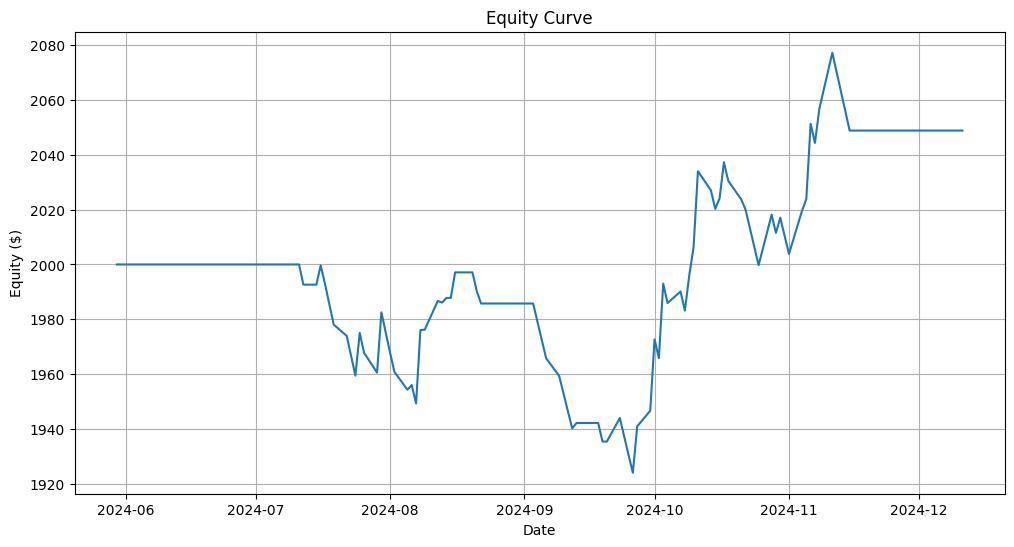

In [ ]:
# Plot equity curve
plt.figure(figsize=(12, 6))
plt.plot(dates, equity_curve)
plt.title("Equity Curve")
plt.xlabel("Date")
plt.ylabel("Equity ($)")
plt.grid()
plt.show()
